In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [4]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import os

In [24]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp('/content/train/', 'train')
test_count = count_exp('/content/test/', 'test')
print(train_count)
print(test_count)

       angry   sad  surprise  happy  disgust  fear  neutral
train   3995  4830      3171   7215      436  4097     4965
      angry   sad  surprise  happy  disgust  fear  neutral
test    958  1247       831   1774      111  1024     1233


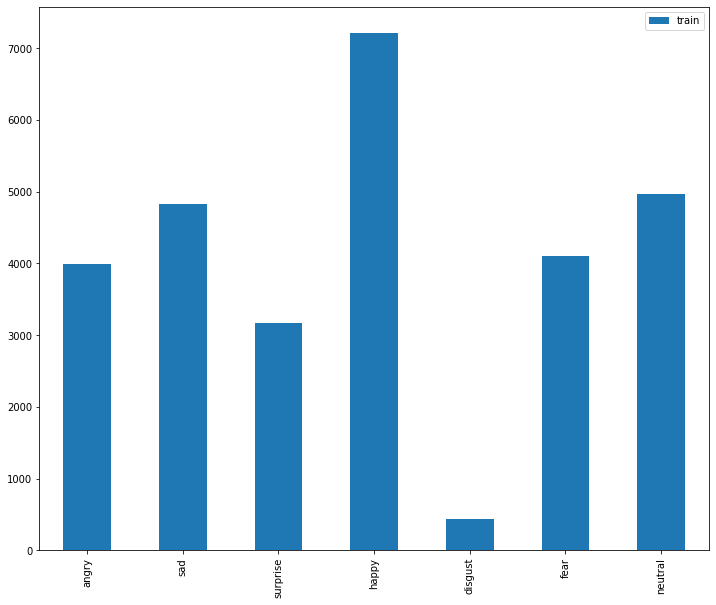

In [25]:
train_count.transpose().plot(kind='bar', figsize=(12,10))

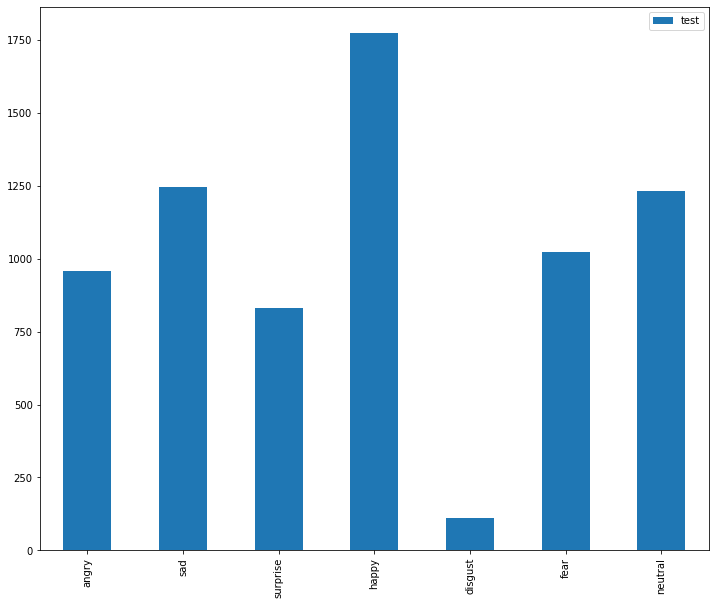

In [26]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

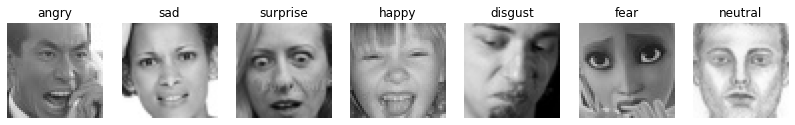

In [28]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir('/content/train'):
    img = load_img(('/content/train/' + expression +'/'+ os.listdir('/content/train/'+ expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [30]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [31]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [32]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


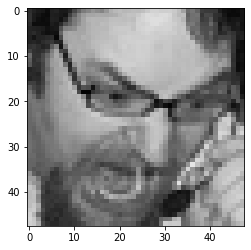

In [33]:
from keras.preprocessing import image
img = image.load_img("/content/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [34]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [35]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [36]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 8192)              32768     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                262176    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)               

In [38]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [52]:

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),  
      #tf.keras.metrics.AUC(name='auc'),
        #f1_score,
]

In [53]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [54]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=)

In [55]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 2,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/2
356/359 [============================>.] - ETA: 1s - loss: 1.8318 - accuracy: 0.8571

KeyboardInterrupt: ignored

In [43]:
score = model.evaluate(test_dataset)
print('Test Accuracy: {}'.format(score[1]))

113/113 [==============================] - 62s 550ms/step - loss: 1.8261 - accuracy: 0.2451
Test Accuracy: 0.24505433440208435


In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

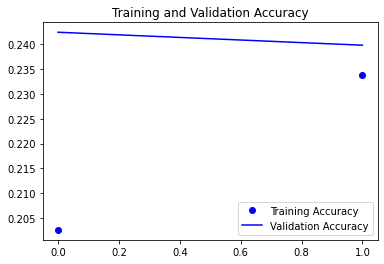

In [45]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

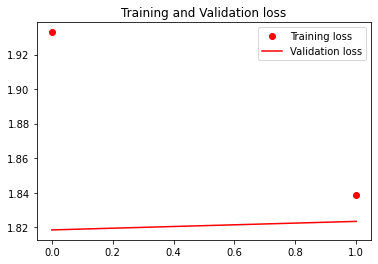

In [46]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [47]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}

Confusion Matrix
[[  32    0   32  795    7    5   87]
 [   6    0    1   96    1    1    6]
 [  43    0   31  826    2   11  111]
 [  64    0   52 1460   11   18  169]
 [  41    0   36 1016    5   10  125]
 [  46    0   28 1030   10   12  121]
 [  26    0   21  688    5    7   84]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.03      0.05       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.03      0.05      1024
       happy       0.25      0.82      0.38      1774
     neutral       0.12      0.00      0.01      1233
         sad       0.19      0.01      0.02      1247
    surprise       0.12      0.10      0.11       831

    accuracy                           0.23      7178
   macro avg       0.14      0.14      0.09      7178
weighted avg       0.17      0.23      0.13      7178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


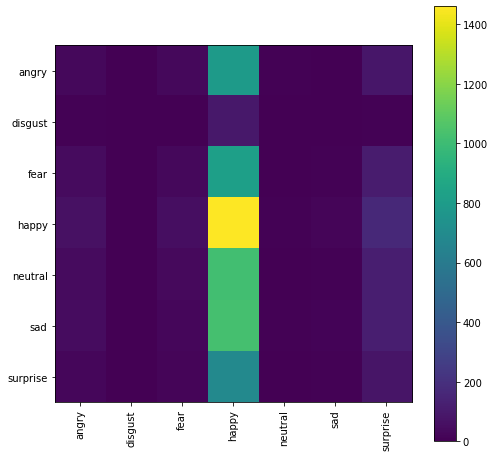

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(test_dataset.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(x_test[i].reshape(48,48,3), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(emotion_dict [predicted_classes[i]], emotion_dict [y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)